# Appendix 2

This Notebook details the different feedforward neural networks investigated for the prediction of ED attendances. This involves changing the number of hidden layers, number of neurons in each layer and using dropout. These models were not selected for the final neural network model for the reasons described.

#### Imports

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import sys

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [2]:
#  Tensorflow imports for neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Used for pre-processing and evaluation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import meanabs

2024-02-14 16:30:37.211902: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-14 16:30:37.254632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Read in Data

In [3]:
# Reads in data and sets the time frequency as daily
attends = pd.read_csv('paediatrics_train.txt', index_col='date',
                      parse_dates=True, dayfirst=False)
attends.index.freq = 'D'

In [4]:
# Sets up the training data so choice of model not biased by looking at the
# test data
train = attends.iloc[:-28]

# Number of days in time series
train.shape

(1028, 1)

In [5]:
# Test set is the last 28 days of the known data
test = attends.iloc[-28:]

test.shape

(28, 1)

#### Required Functions and Pre-processing

In [6]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    Sliding window that puts data in a format used by the neural network.

    Parameters:
    -----------
    train: array-like
        Training data.
    window_size: int, optional (default=2)
        Lookback (how much lagged data to include).
    horizon: int, optional (default=1)
        Number of observations ahead to predict.

    Returns:
    ---------
    Preprocessed X: array-like

    Preprocessed Y: array-like
    '''
    tabular_X = []
    tabular_y = []

    for i in range(0, len(train) - window_size - horizon + 1):
        X_train = train.iloc[i:window_size+i]
        y_train = train.iloc[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)

    return (np.asarray(tabular_X),
            np.asarray(tabular_y).reshape(-1, ))

In [7]:
def array_test_train_split(*arrays, train_size):
    '''
    Performs test/train split.

    Parameters:
    -----------
    arrays: np.ndarray
        Arrays to be split.
    train_size: int
        Size of training set.

    Returns:
    ---------
    Results:
        Test/train split of each array.
    '''
    results = ()
    for arr in arrays:
        results += arr[:train_size], arr[train_size:]

    return results

In [8]:
window_size = 28
# Creates X and y data required for neural network
X_data, y_data = sliding_window(attends, window_size=window_size,
                                horizon=28)

# Splits into test/train sets
train_size = len(y_data) - 28
X_train, X_test, y_train, y_test = array_test_train_split(X_data, y_data,
                                                        train_size=train_size)

In [9]:
def scale_arrays_of_X(X_to_scale, scaler):
    '''
    Transforms data using a sklearn scaler.

    Parameters:
    ------------
    X_to_scale: np.ndarray
        Sliding windows of X data.
    scaler: MinMaxScaler
        Fitted scaler used to transform X_train.

    Returns:
    -------
    X_scaled: np.ndarray
        Scaled data with dimensions the same as X_train.
    '''
    X_scaled = []

    for sample in X_to_scale:
        # Scale the sample and store in list
        scaled_sample = scaler.transform(sample.reshape(-1, 1))
        X_scaled.append(scaled_sample)

    # Scaled data returned as np.ndarray with same dimensions as input
    return np.array(X_scaled).reshape(len(X_scaled), -1)

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# Scale on training data to fit
scaler.fit(train.iloc[:-28].to_numpy().reshape(-1, 1))

# Scale all data
y_train = scaler.transform(y_train.reshape(-1, 1))
X_train = scale_arrays_of_X(X_train, scaler)
X_test = scale_arrays_of_X(X_test, scaler)
y_test = scaler.transform(y_test.reshape(-1, 1))

In [11]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive model using the iterative
    prediction method.

    Conduct h one-step forecasts gradually replacing ground truth
    autoregressive X values with predictions.

    Parameters:
    -----------
    model: forecast object
        Model that has a .predict(h) interface.
    exog: array-like
        Initial vector of lagged values (X).
    h: int
        Forecast horizon. Assumed to be > 0.

    Returns:
    --------
    numpy.ndarray
        Predictions.
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        # Uses model to get predictions
        y_pred = model.predict(current_X.reshape(1, -1), verbose=None)[0,0]
        y_preds.append(y_pred)

        # Adds prediction to the current_X list to be used in next prediction
        current_X = np.roll(current_X, shift=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [12]:
def plot_prediction(model, X_train, y_train, y_test, y_preds):
    '''
    Plots prediction from NN model against the training and test data.

    Parameters:
    -----------
    model:
        Sequential neural network model.
    X_train: np.ndarray
        Training data.
    y_train: np.ndarray
        Training data.
    y_test: np.ndarray
        Test data.
    y_preds: np.ndarray
        Predicted values.

    Returns:
    --------
    Plot of prediction against actual.

    '''
    fitted_values = scaler.inverse_transform(model.predict(X_train))
    ground_truth = scaler.inverse_transform(y_train)
    ground_truth_val = scaler.inverse_transform(y_test)

    # Adds NAN values up to where predictions/test start or else plots at 0
    padding = np.full(len(fitted_values), np.NAN)
    validation = np.concatenate([padding.reshape(-1, 1), ground_truth_val])
    forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

    plt.plot(ground_truth, label='ground truth')
    plt.plot(validation, label='test')
    plt.plot(fitted_values, label='in-sample', linestyle='-.')
    plt.plot(forecast, label='out-of-sample', linestyle='-.')
    plt.legend();

In [13]:
def get_network_model(window_size, lr=0.01, include_2hidden=False, n_neuron1=5,
                      n_neuron2=15, include_drop_out=False, drop_out_rate=0.2,
                      metrics=['mse']):
    '''
    Sequential Keras MLP model.

    Parameters:
    -----------
    window_size: int
        Size of lookback.
    lr: float, optional (default=0.01)
        Learning rate of NN.
    include_2hidden: bool, optional (default=False)
        Whether a second hidden layer should be used.
    n_neuron1: int, optional (default=5)
        Number of neurons in first hidden layer.
    n_neuron2: int, optional (default=15)
        Number of neurons in second hidden layer.
    include_drop_out: bool, optional (default=False)
        If included, some neurons are dropped out during training.
    drop_out_rate: float, optional (default=0.2)
        How many neurons to drop out.
    metrics: list of str, optional (default=['mse'])
        Model metrics.

    Returns:
    --------
    model: model object
        Sequential neural network.

    '''
    model = Sequential()

    model.add(Flatten(input_shape=(window_size,)))
    # Hidden Layer 1
    model.add(Dense(units=n_neuron1, activation='relu'))
    # Hidden Layer 2
    if include_2hidden:
        model.add(Dense(units=n_neuron2, activation='relu'))
    # Drop-out
    if include_drop_out:
        model.add(Dropout(drop_out_rate))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics=metrics)

    return model

In [14]:
def fit_predict_model(lr=0.01, include_2hidden=False, n_neuron1=5,
                      n_neuron2=15, include_drop_out=False, drop_out_rate=0.2):
    '''
    Creates network model, fits to data and prints out validation loss and
    training loss.

    Parameters:
    -----------
    lr: float, optional (default=0.01)
        Learning rate of NN.
    include_2hidden: bool, optional (default=False)
        Whether a second hidden layer should be used.
    n_neuron1: int, optional (default=5)
        Number of neurons in first hidden layer.
    n_neuron2: int, optional (default=15)
        Number of neurons in second hidden layer.
    include_drop_out: bool, optional (default=False)
        If included, some neurons are dropped out during training.
    drop_out_rate: float, optional (default=0.2)
        How many neurons to drop out.

    Returns:
    --------
    model_mlp: model object
        Sequential neural network.
    y_preds_mlp: numpy.ndarray
        Predictions from model

    '''
    # Random seed to ensure repeatability
    tf.keras.utils.set_random_seed(1234)

    n_epochs = 100
    # Helps prevent overfitting
    es = EarlyStopping(monitor='loss', patience=10)

    # Creates model and fits to the data
    model_mlp = get_network_model(28, lr=lr, include_2hidden=include_2hidden,
                                  n_neuron1=n_neuron1, n_neuron2=n_neuron2,
                                  include_drop_out=include_drop_out,
                                  drop_out_rate=drop_out_rate)
    results_mlp = model_mlp.fit(x=X_train,
                                y=y_train,
                                epochs=n_epochs,
                                validation_data=(X_test, y_test),
                                verbose=0,
                                callbacks=[es])

    # Plots loss of training and validation sets
    plt.plot(results_mlp.history['loss'], label='loss')
    plt.plot(results_mlp.history['val_loss'], label='val_loss')
    plt.legend()

    # Predict next 28 days
    horizon = 28
    y_preds_mlp = autoregressive_iterative_forecast(model_mlp, X_test[0],
                                                h=horizon)
    y_preds_mlp = scaler.inverse_transform(y_preds_mlp.reshape(-1, 1))

    return model_mlp, y_preds_mlp

#### Model 1

**Parameter change**: Additional neuron in hidden layer.

**Result**: Model is overfit as validation loss increases.

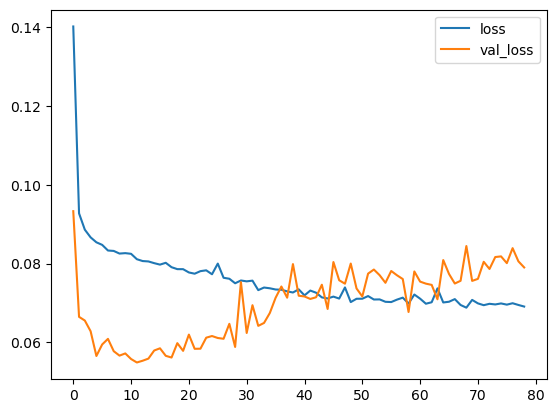

In [15]:
model_mlp, y_preds_mlp = fit_predict_model(n_neuron1=6)

1/1 [==============================] - 0s 15ms/step


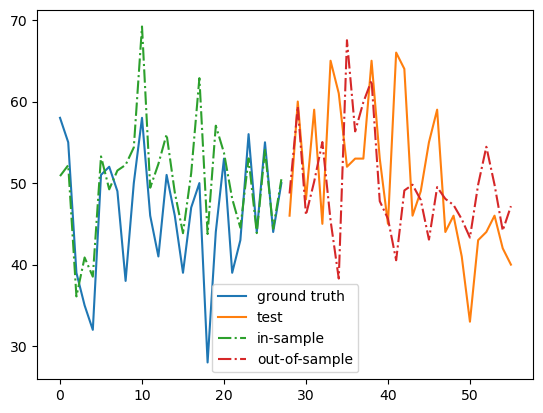

In [16]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)

#### Model 2

**Parameter change**: Second hidden layer.

**Result**: Model is overfit as validation loss increases.

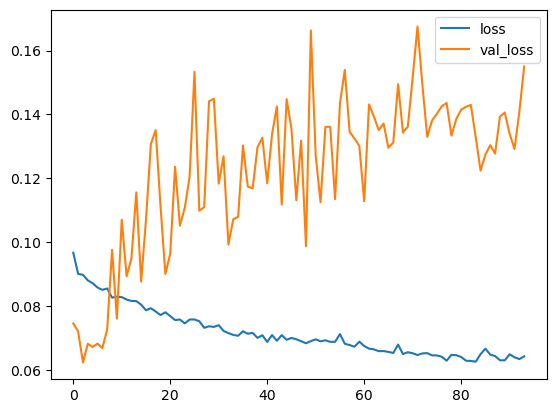

In [17]:
model_mlp, y_preds_mlp = fit_predict_model(include_2hidden=True)

1/1 [==============================] - 0s 16ms/step


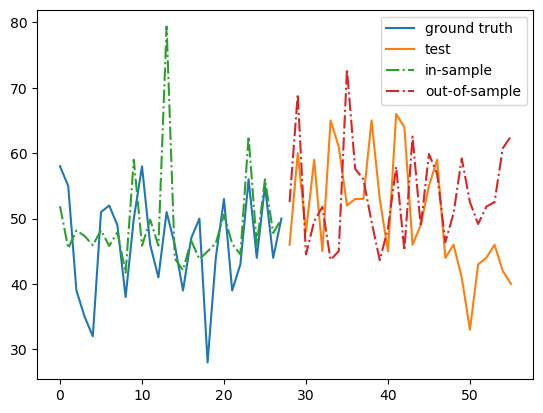

In [18]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)

#### Model 3

**Parameter change**: Second hidden layer with drop-out.

**Result**: Validation loss is unstable and hardly changes.

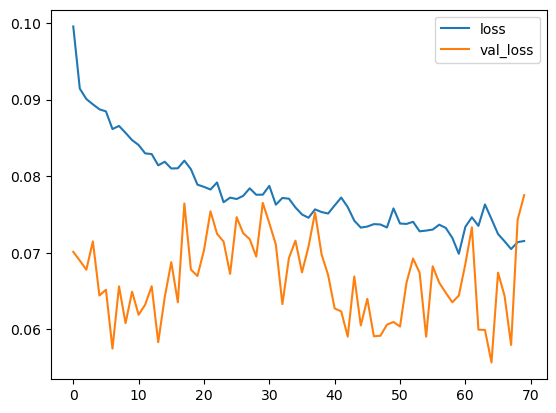

In [19]:
model_mlp, y_preds_mlp = fit_predict_model(include_2hidden=True,
                                           include_drop_out=True)

1/1 [==============================] - 0s 17ms/step


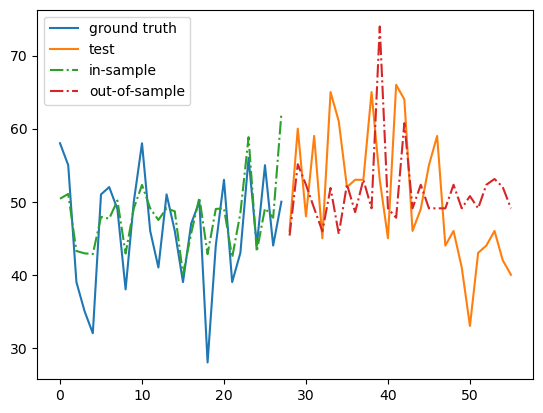

In [20]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)

#### Model 4

**Parameter change**: Second hidden layer with fewer number of neurons in the layers and drop-out.

**Result**: Validation loss more unstable.

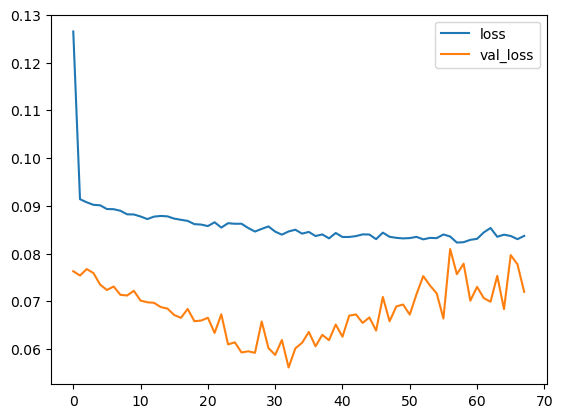

In [21]:
model_mlp, y_preds_mlp = fit_predict_model(include_2hidden=True,
                                           n_neuron1=2, n_neuron2=5,
                                           include_drop_out=True)

1/1 [==============================] - 0s 24ms/step


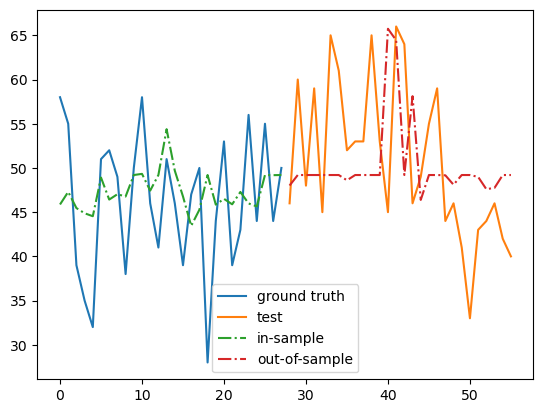

In [22]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)

#### Model 5

**Parameter change**: Fewer neurons in 1 hidden layer.

**Result**: Validation loss increase.

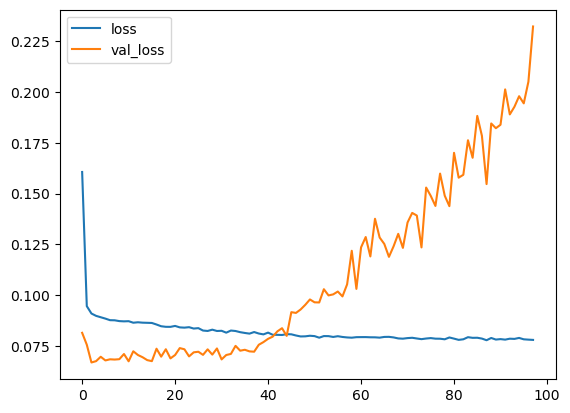

In [23]:
model_mlp, y_preds_mlp = fit_predict_model(n_neuron1=4)

1/1 [==============================] - 0s 37ms/step


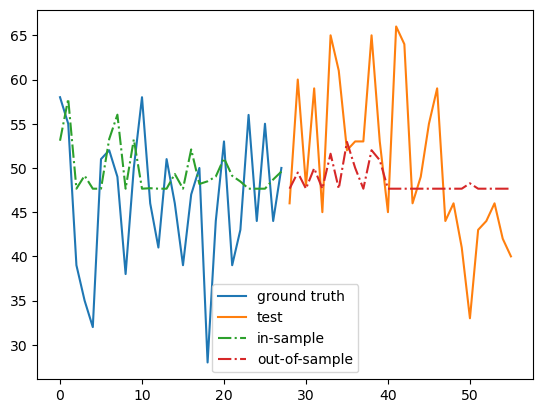

In [24]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)

#### Model 6

**Parameter change**: Fewer neurons in 1 hidden layer and dropout.

**Result**: Little change in validation loss so model not learning.

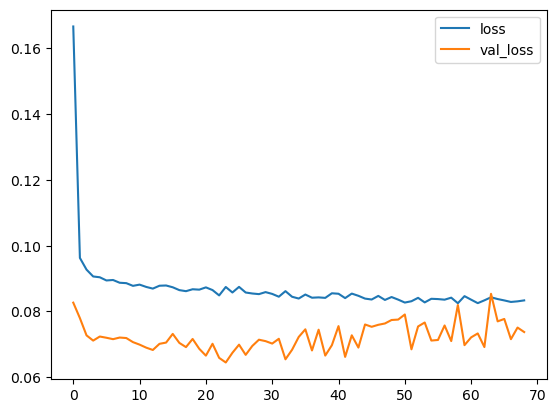

In [25]:
model_mlp, y_preds_mlp = fit_predict_model(n_neuron1=4,
                                           include_drop_out=True)

1/1 [==============================] - 0s 26ms/step


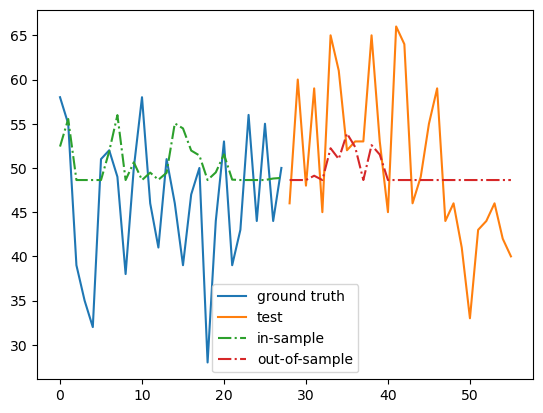

In [26]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)

#### Model 7

**Parameter change**: Quicker learning rate.

**Result**: Model not learning as validation error hardly changes.

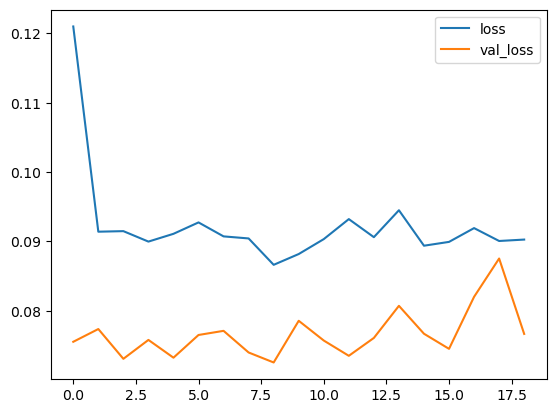

In [27]:
model_mlp, y_preds_mlp = fit_predict_model(lr=0.1)

1/1 [==============================] - 0s 22ms/step


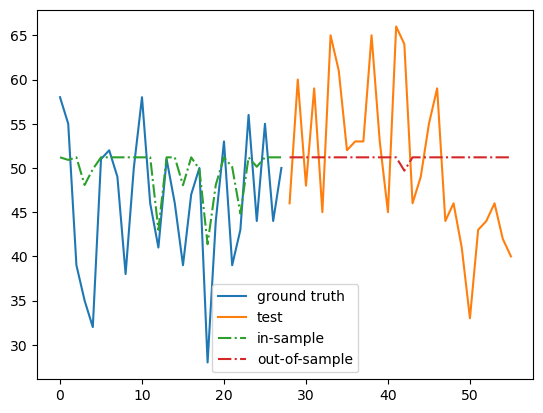

In [28]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)

#### Model 8

**Parameter change**: More neurons in 1 hidden layer and dropout.

**Result**: Model starts to overfit.

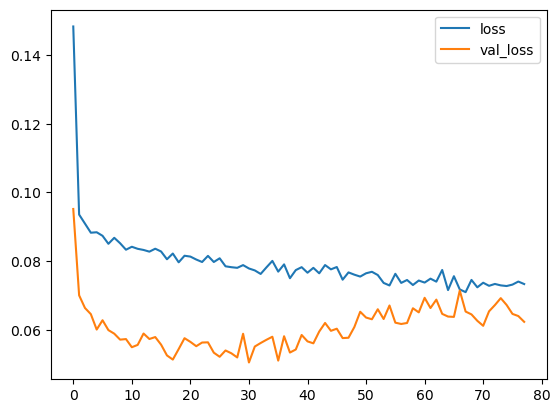

In [29]:
model_mlp, y_preds_mlp = fit_predict_model(n_neuron1=8,
                                           include_drop_out=True)

1/1 [==============================] - 0s 26ms/step


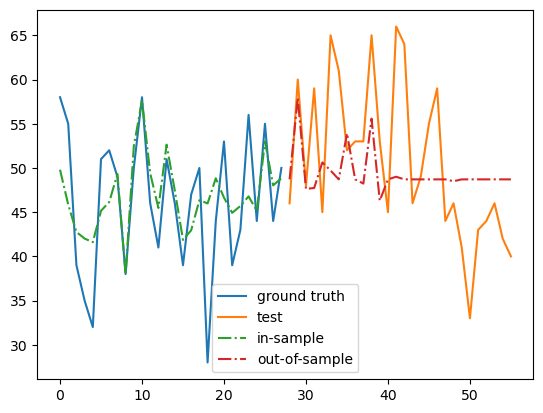

In [30]:
plot_prediction(model_mlp, X_train[-28:], y_train[-28:], y_test, y_preds_mlp)